In [1]:
import numpy as np
import numpy.random as ra
import xarray as xr
import torch
import matplotlib.pyplot as plt
from pyoptmat import experiments
from maker import make_model
device="cpu"

/home/mark/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters to generate single load history
max_strain = 0.01
tension_hold = 5*60.0
R = -1.0
strain_rate = 1e-3
compression_hold = 1.0e-6
temperature = 500.0
# Number of cycles
N = 50
# Time steps
nload = 20
nhold = 20
scale = 0.1

In [3]:
# Actually generate the data -- can be expensive
times, strains, cycles = experiments.sample_cycle_normalized_times(
    {
        "max_strain": max_strain,
        "R": R,
        "strain_rate": strain_rate,
        "tension_hold": tension_hold,
        "compression_hold": compression_hold
    }, N, nload, nload)
times = torch.tensor(times)
strains = torch.tensor(strains)
temperatures = torch.full_like(times, temperature)
model = make_model(
    torch.tensor(0.5, device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale), device=device),
    torch.tensor(ra.normal(0.5, scale, size=(3,)), device=device),
    torch.tensor(ra.normal(0.5, scale, size=(3,)), device=device),
    device=device)
with torch.no_grad():
    results = model.solve_strain(times.unsqueeze(-1), strains.unsqueeze(-1), temperatures.unsqueeze(-1))
results = results.squeeze(1)
stress = results[:,0]

In [199]:
# Now actually start playing around with SVDs
keep = 0.75
ntruncate = int(results.shape[0]*keep)
partial_results = results[:ntruncate]

In [200]:
# Start with stress
partial_stress = partial_results[:,0]
# Actual SSA
N = partial_stress.shape[0]
#L = 2*nload + 2*nhold # This is probably optimal
L = 2*(2*nload + 2*nhold)
K=N-L+1
X=torch.column_stack([partial_stress[i:i+L] for i in range(0,K)])
U, S, Vh = torch.linalg.svd(X)
V = Vh.mH
X_elem = [S[i] * torch.outer(U[:,i], V[:,i]) for i in range(S.shape[0])]
XtoF = lambda Xi: torch.tensor([Xi.flip(0).diagonal(i).mean() for i in range(-Xi.shape[0]+1, Xi.shape[1])])

Reconstruction error: 9.784508e+01


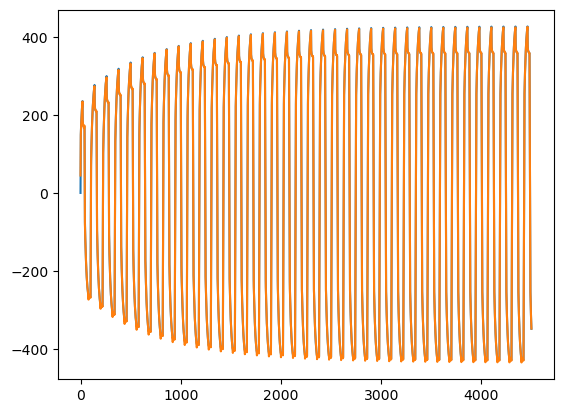

In [214]:
# Reconstruction
use=L//2
reconstruction = sum(XtoF(X_elem[i]) for i in range(use))
error_reconstruction = torch.linalg.norm(reconstruction - partial_stress)
print("Reconstruction error: %e" % error_reconstruction)
plt.plot(partial_stress)
plt.plot(reconstruction)

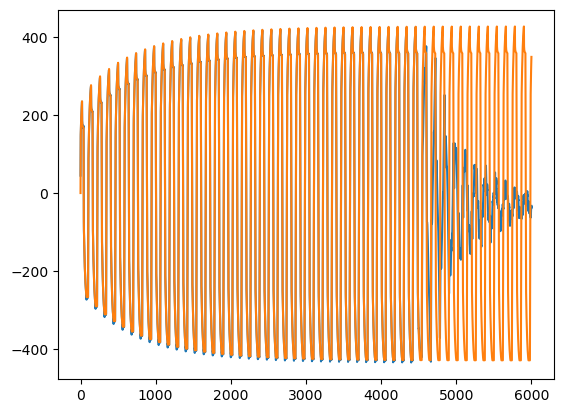

In [215]:
# Prediction
pi=U[-1,:use]
vs=torch.sum(pi**2.0)
A=1.0/(1-vs)*torch.matmul(U[:-1,:use],pi)
prediction=torch.zeros_like(stress)
prediction[:ntruncate]=reconstruction
for i in range(ntruncate,prediction.shape[0]):
    prediction[i] = torch.sum(A*prediction[i-L:i-1])
plt.plot(prediction)
plt.plot(stress)